In [539]:
library(dplyr)
library(lme4)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(MuMIn)
library(here)
library(reactablefmtr)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)
require(vegan)
require(knitr)
require(ggpubr)
library(ggeffects)
library(janitor)
library(sjPlot)
library(factoextra)

In [540]:
setwd(here::here())

In [541]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")

In [542]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")


In [543]:
# set plot dimensions
options(repr.plot.width = 15)
options(repr.plot.height = 10)

__For running each peice of code press shift + Enter__

# __Q3:How do functional traits, treatment, and N-fixing status interact to influence seedling-level growth rates and biomass accumulation?__


## PCA


In [544]:
# Select variables that are going to be used in the model
data_for_models <-
    data_for_models %>%

    clean_names() %>%
    # Select columns needed for regression
    dplyr::select(spcode, treatment, nfixer, init_height,

                  # Performance measures
                  total_biomass, rgr, root_shoot_ratio,

                  # physiology traits
                  amax, gs, wue,

                  # Leaf traits
                  narea_g_m2, d13c, sla) %>%
    clean_names()

In [725]:
# Center and scale by 2 as Gelman et al 2008

data_traits_scaled <-
    data_for_models %>%
        select(-c(total_biomass, rgr, root_shoot_ratio, init_height)) %>%
        mutate(across(where(is.numeric), scale))

In [727]:
pca_traits <- princomp(data_traits_scaled[,c(4:ncol(data_traits_scaled))])

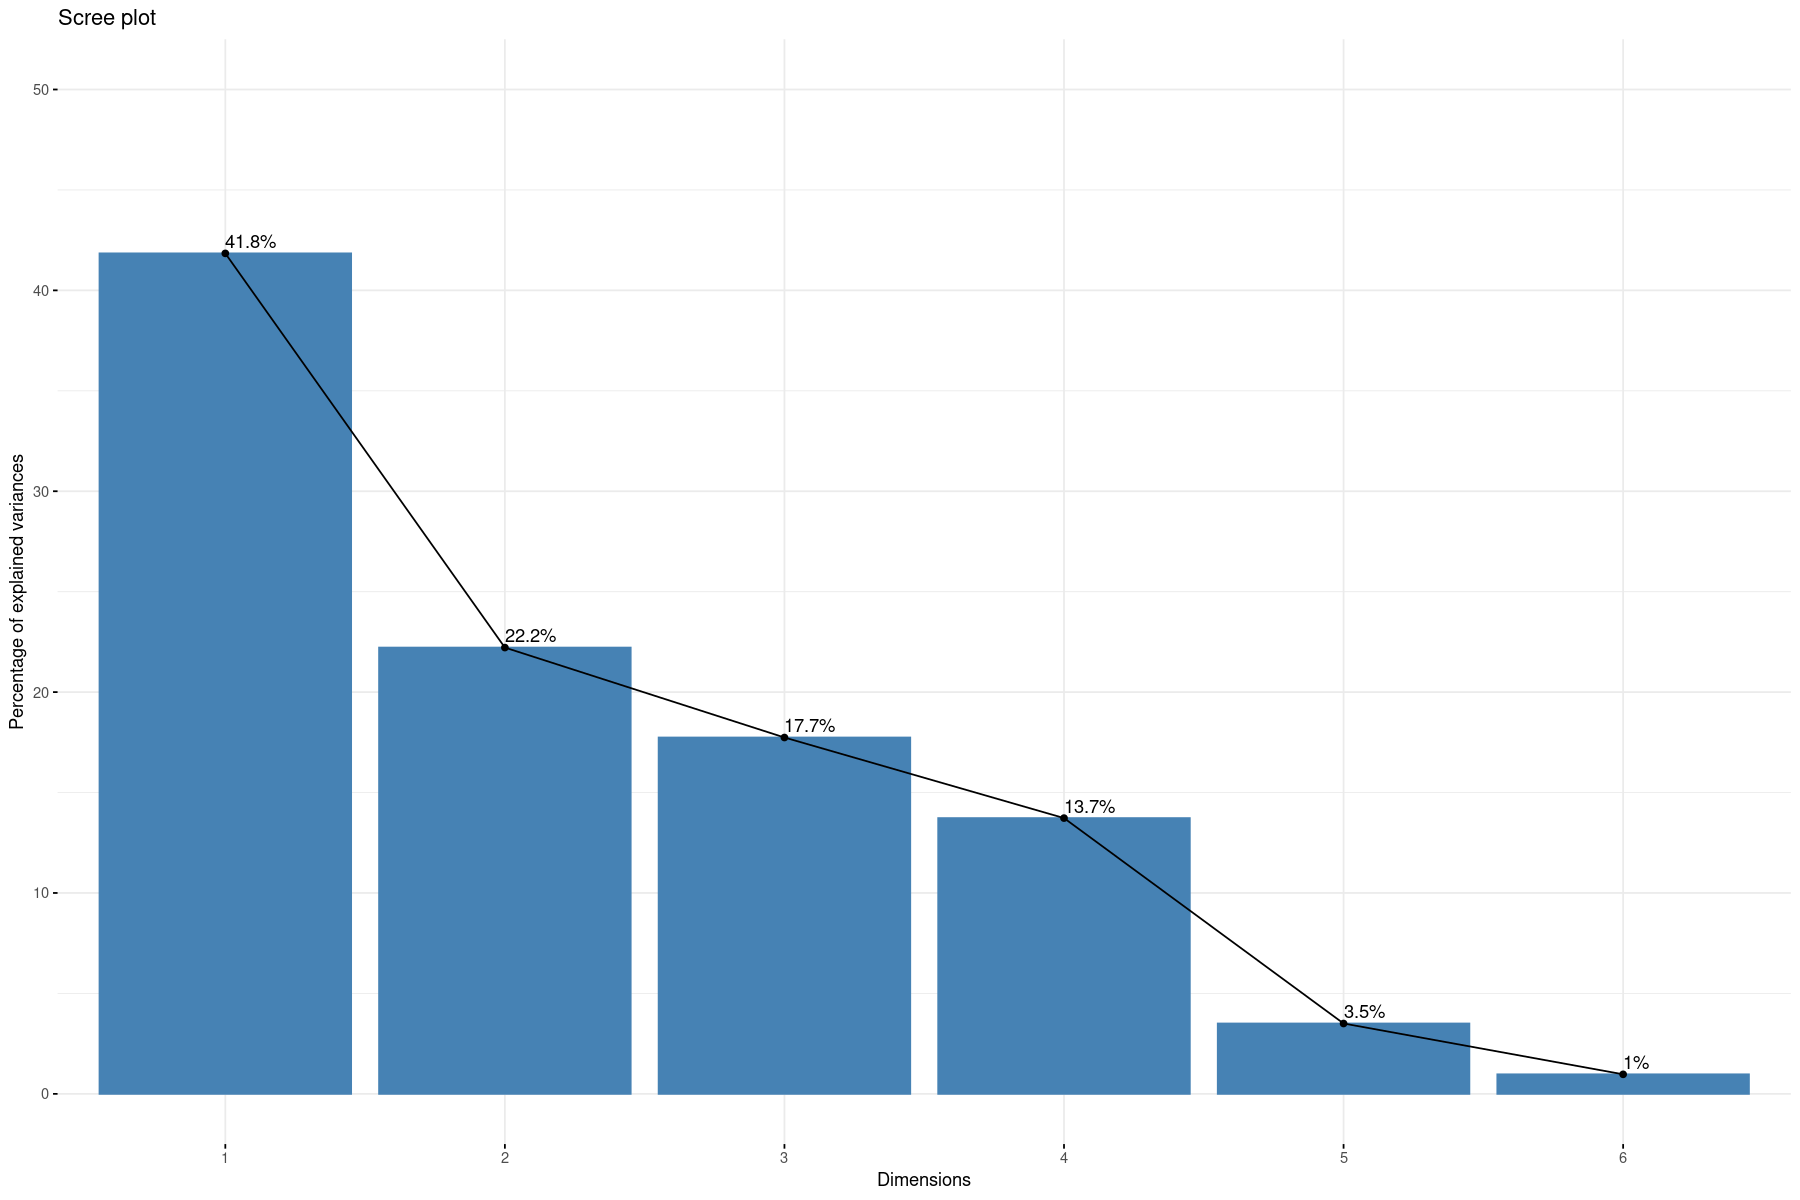

In [728]:
fviz_screeplot(pca_traits, addlabels = TRUE, ylim = c(0, 50))

In [729]:
# Extract loadings
pca_traits$loadings


Loadings:
           Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
amax        0.601  0.109  0.198         0.107  0.759
gs          0.169  0.718  0.287  0.391  0.301 -0.360
wue         0.475 -0.474  0.117 -0.231  0.558 -0.414
narea_g_m2  0.583               -0.129 -0.711 -0.349
d13c        0.199 -0.239 -0.588  0.743              
sla               -0.426  0.714  0.474 -0.278       

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.167  0.167  0.167  0.167  0.167  0.167
Cumulative Var  0.167  0.333  0.500  0.667  0.833  1.000

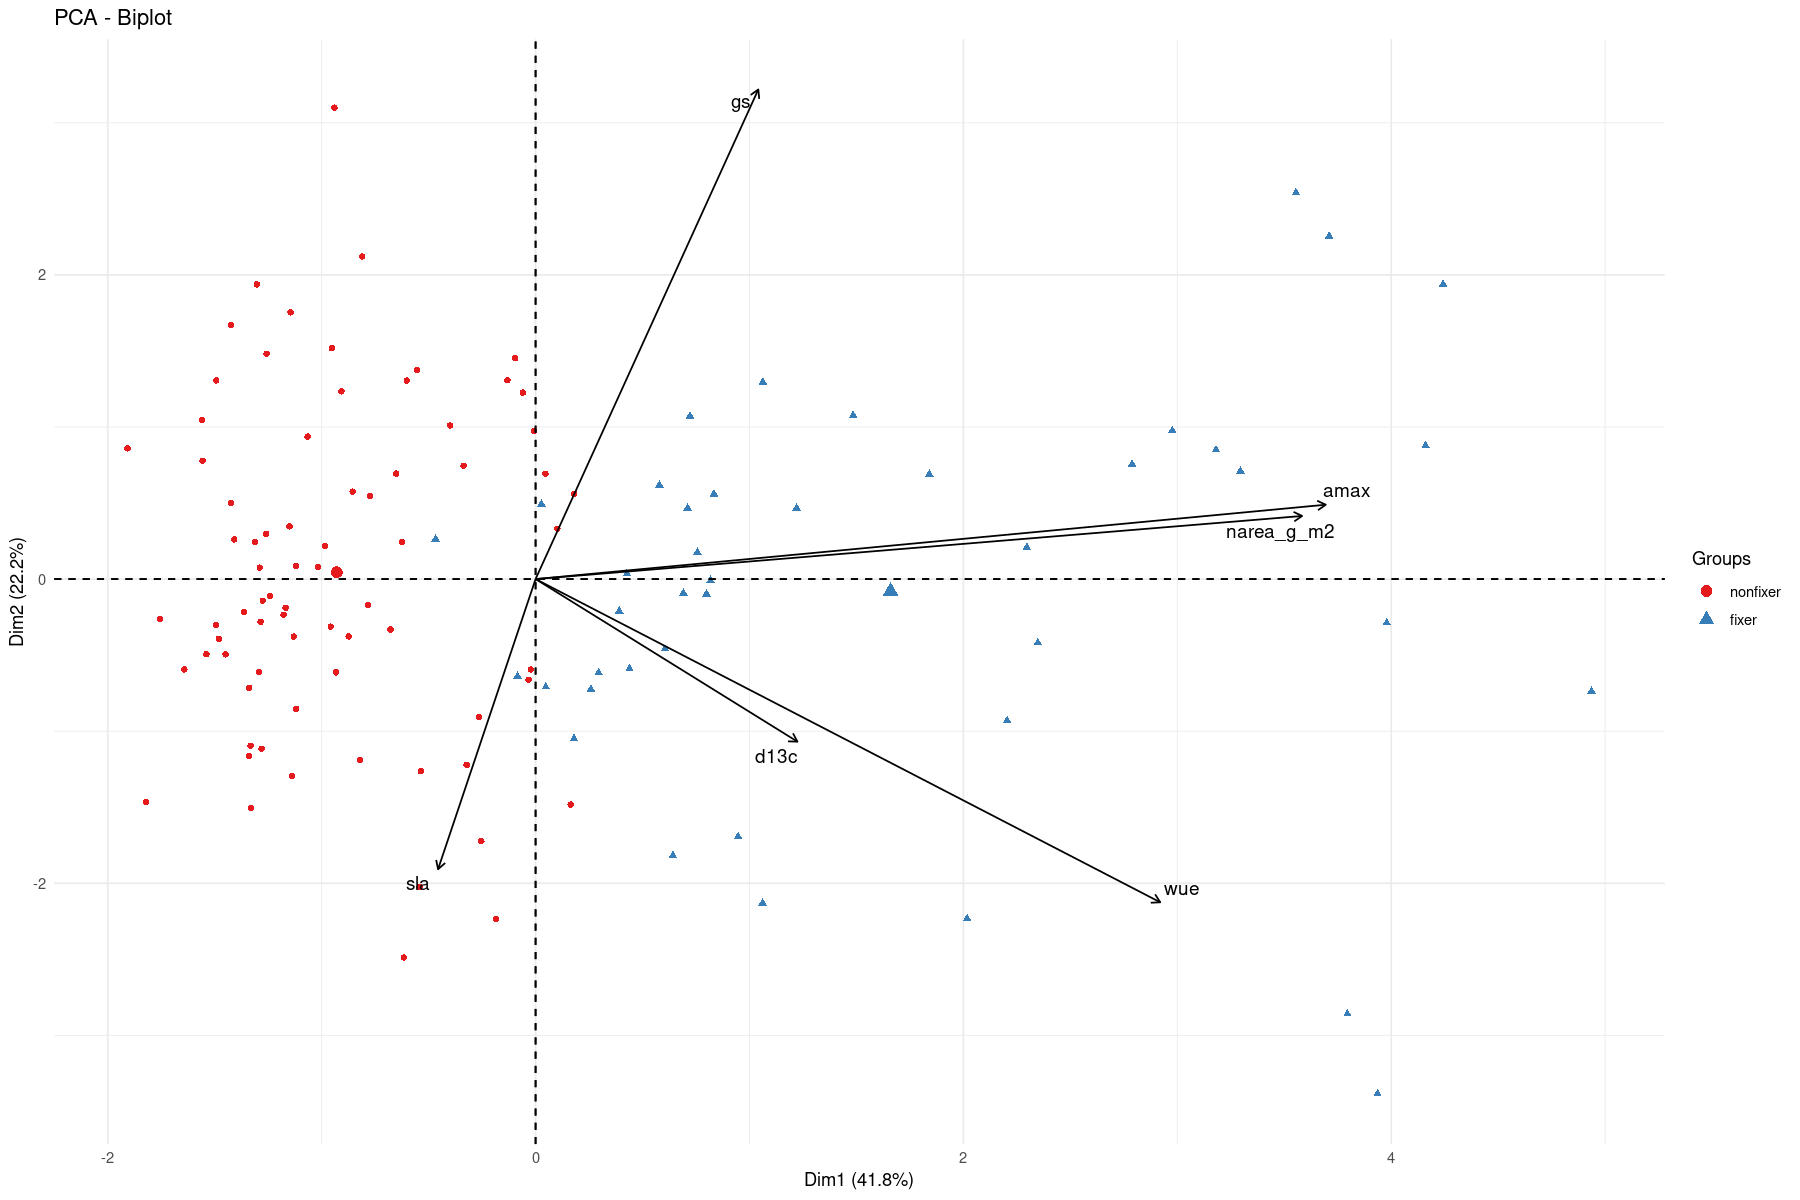

In [730]:
fviz_pca_biplot(pca_traits,axes = c(1, 2),

                # Add group
                habillage= data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

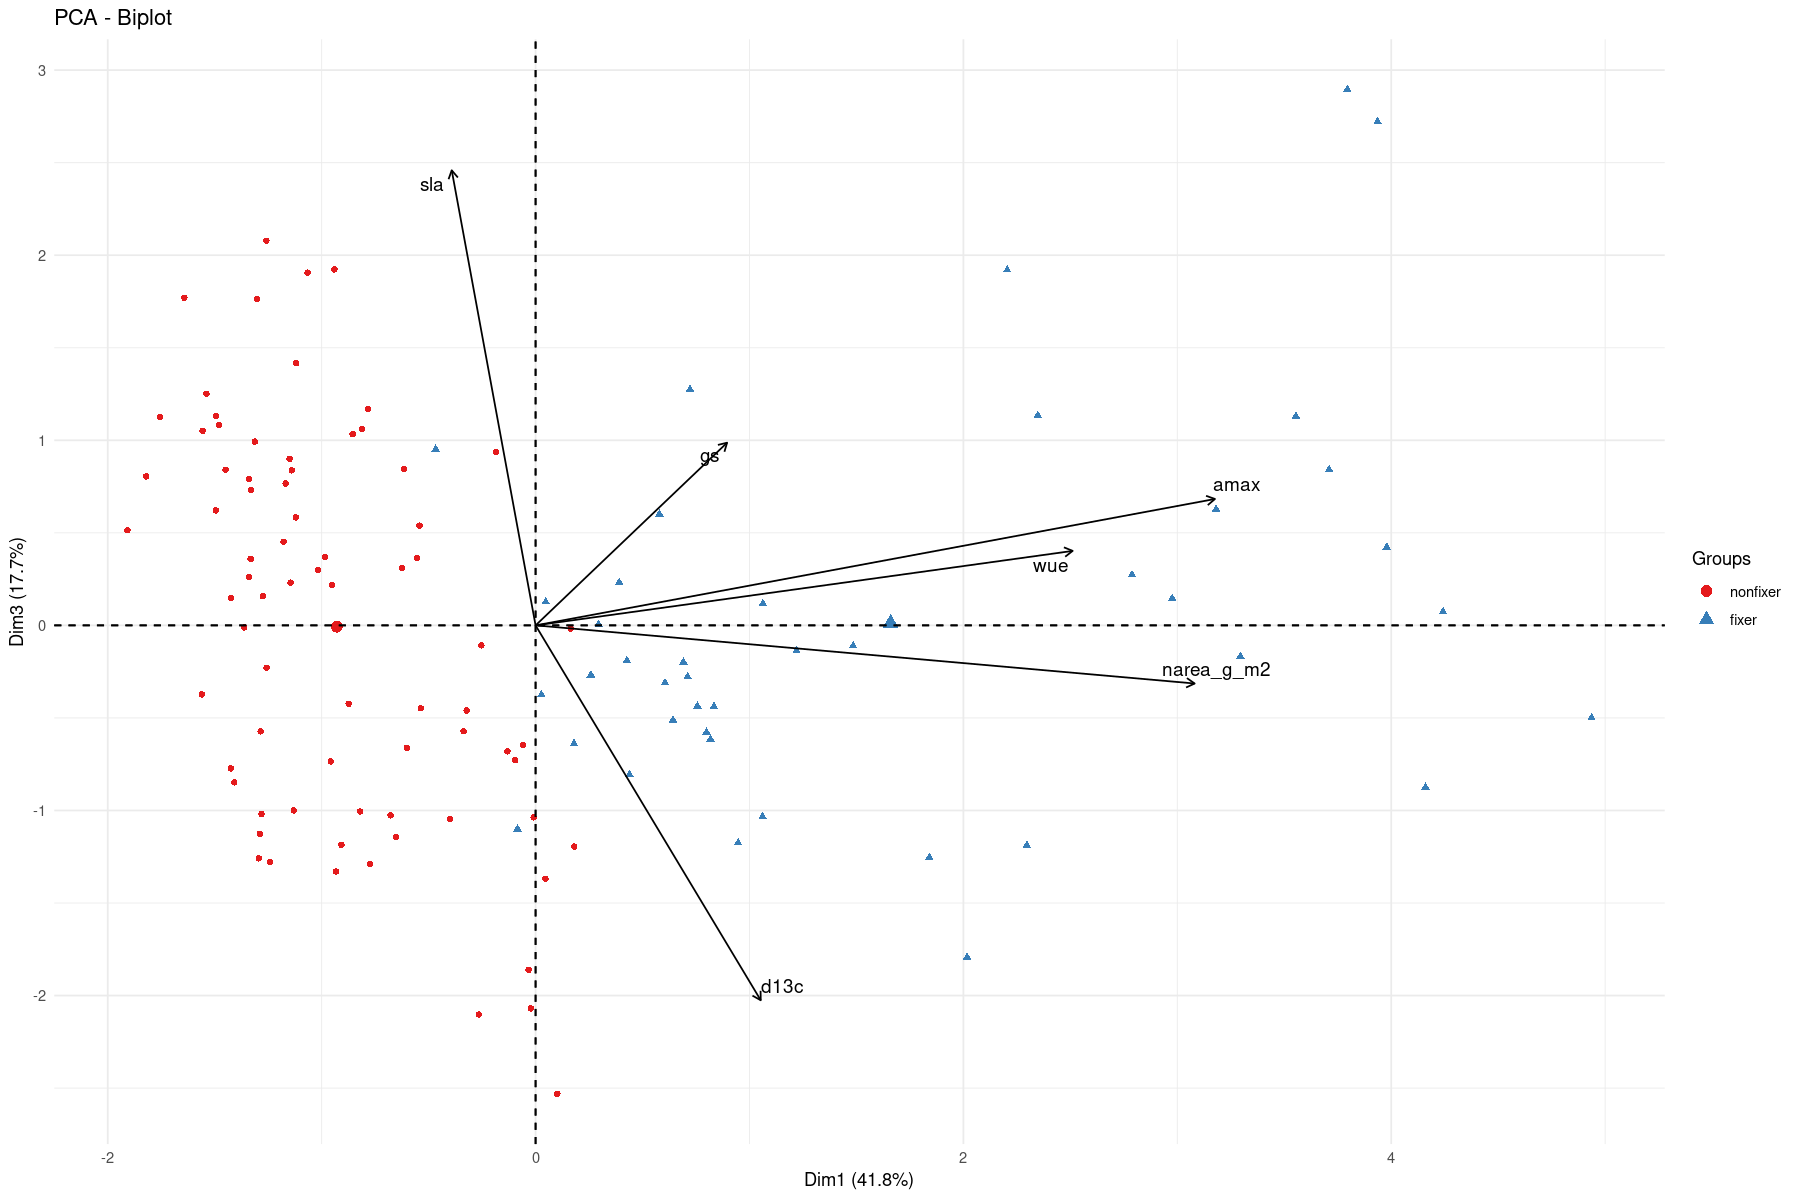

In [731]:
fviz_pca_biplot(pca_traits,axes = c(1, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

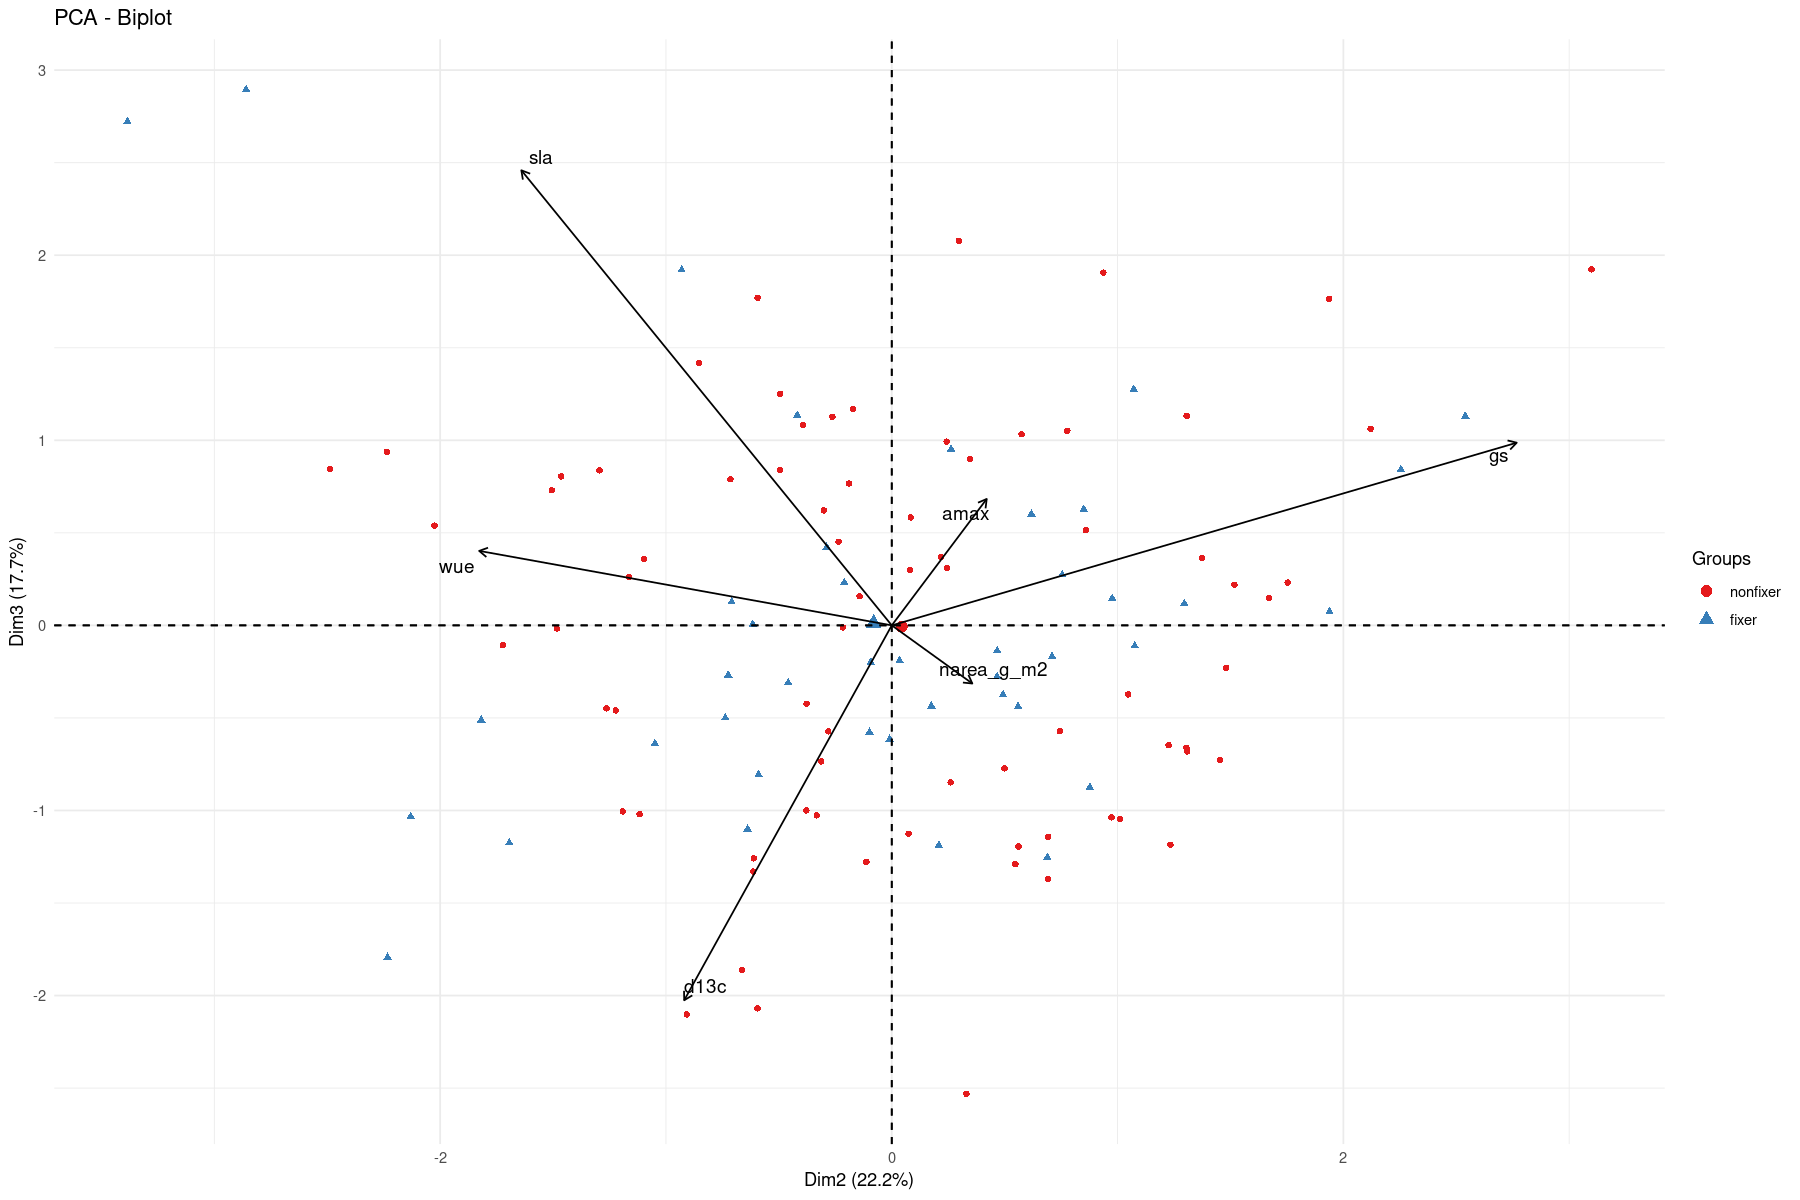

In [732]:
fviz_pca_biplot(pca_traits,axes = c(2, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

## Biplots interpretation
[PCA interpretation](https://wilkelab.org/SDS375/slides/dimension-reduction-1.html#18)

+ The first 3 PCs explains 81% (47.9,19.4,15.8) of the variability in the data
+ PC1 separates fixers from non-fixers
+ All traits contribute positively to PC1 

+ PC1 represents the overall high photosynthetic capacity 
+ PC2 represents the difference between stomatal conductance and SLA
+ PC3 represents the difference between d13c and SLA

## Regression models 

$$response\sim treatment*fixer*PCn\ + initial\ height\ + random(1|specie)$$

In [733]:
pca_scores <- scores(pca_traits)

In [734]:
data_performance <-

    data_for_models %>%
        select(-c(amax, gs,wue, narea_g_m2,	d13c, sla))

In [735]:
data_for_regression_scaled_traits <-
    inner_join(data_performance, data_traits_scaled, , by = c("treatment","spcode", "nfixer"))


Warning message in inner_join(data_performance, data_traits_scaled, , by = c("treatment", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [736]:
# add t-ratio
emm_options(contrast = list(infer = c(TRUE, TRUE)))

### Total biomass

In [737]:
model_pc_total_biomass <- lmer(total_biomass ~  treatment * amax +
                                                treatment * gs  +
                                                treatment * d13c +
                                                treatment * sla +

                                                nfixer * amax +
                                                nfixer * gs  +
                                                nfixer * d13c +
                                                nfixer * sla +


                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

### Relative Growth Rate

In [738]:
model_pc_rgr <- lmer(rgr ~  treatment * amax +
                            treatment * gs  +
                            treatment * d13c +
                            treatment * sla +

                            nfixer * amax +
                            nfixer * gs  +
                            nfixer * d13c +
                            nfixer * sla +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

### Root to shoot ratio

In [739]:
model_pc_root_shoot <- lmer(root_shoot_ratio ~  treatment * amax +
                                                treatment * gs  +
                                                treatment * d13c +
                                                treatment * sla +

                                                nfixer * amax +
                                                nfixer * gs  +
                                                nfixer * d13c +
                                                nfixer * sla +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

## Model Assumptions

[1] "No variable specified inthe variables argument"


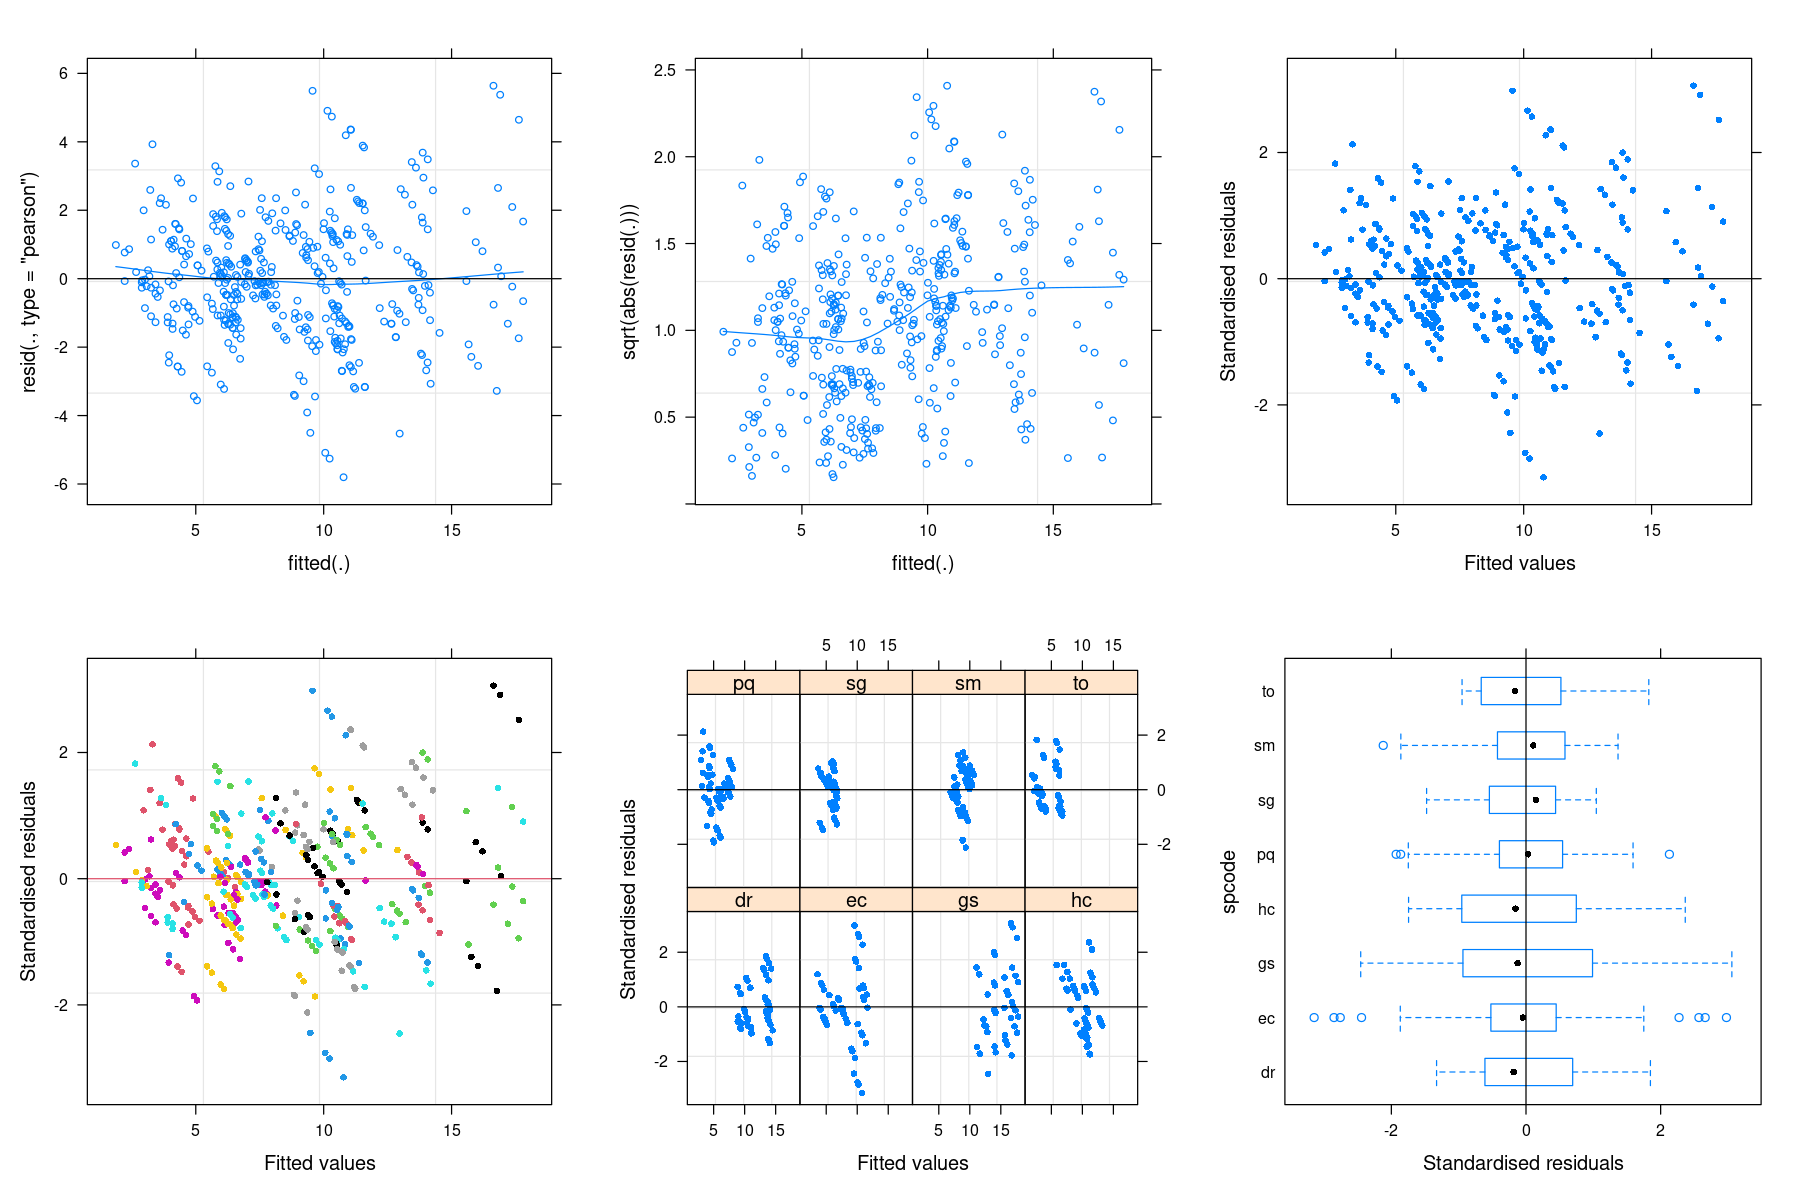

In [740]:
par(mfrow = c(3,3))
validation_plots(model_pc_total_biomass, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


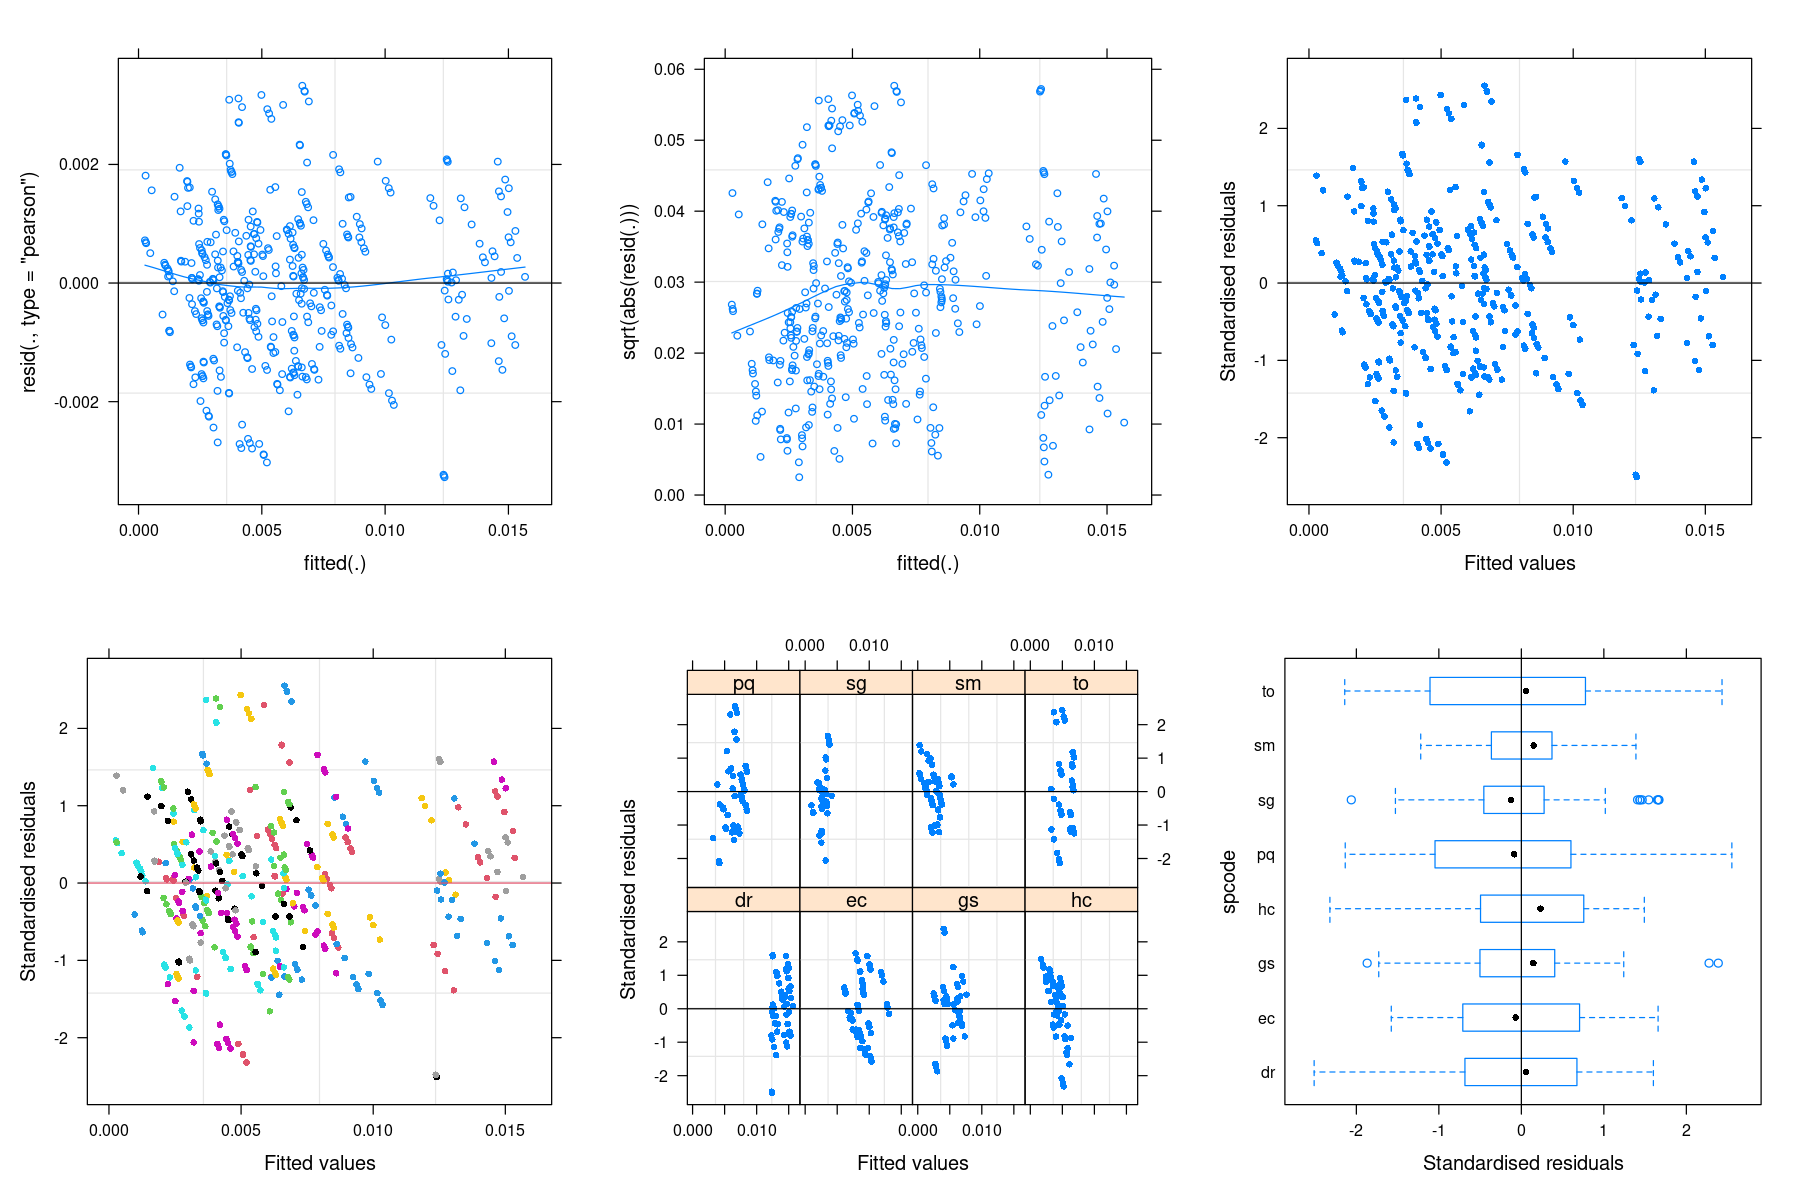

In [741]:
par(mfrow = c(3,3))
validation_plots(model_pc_rgr, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


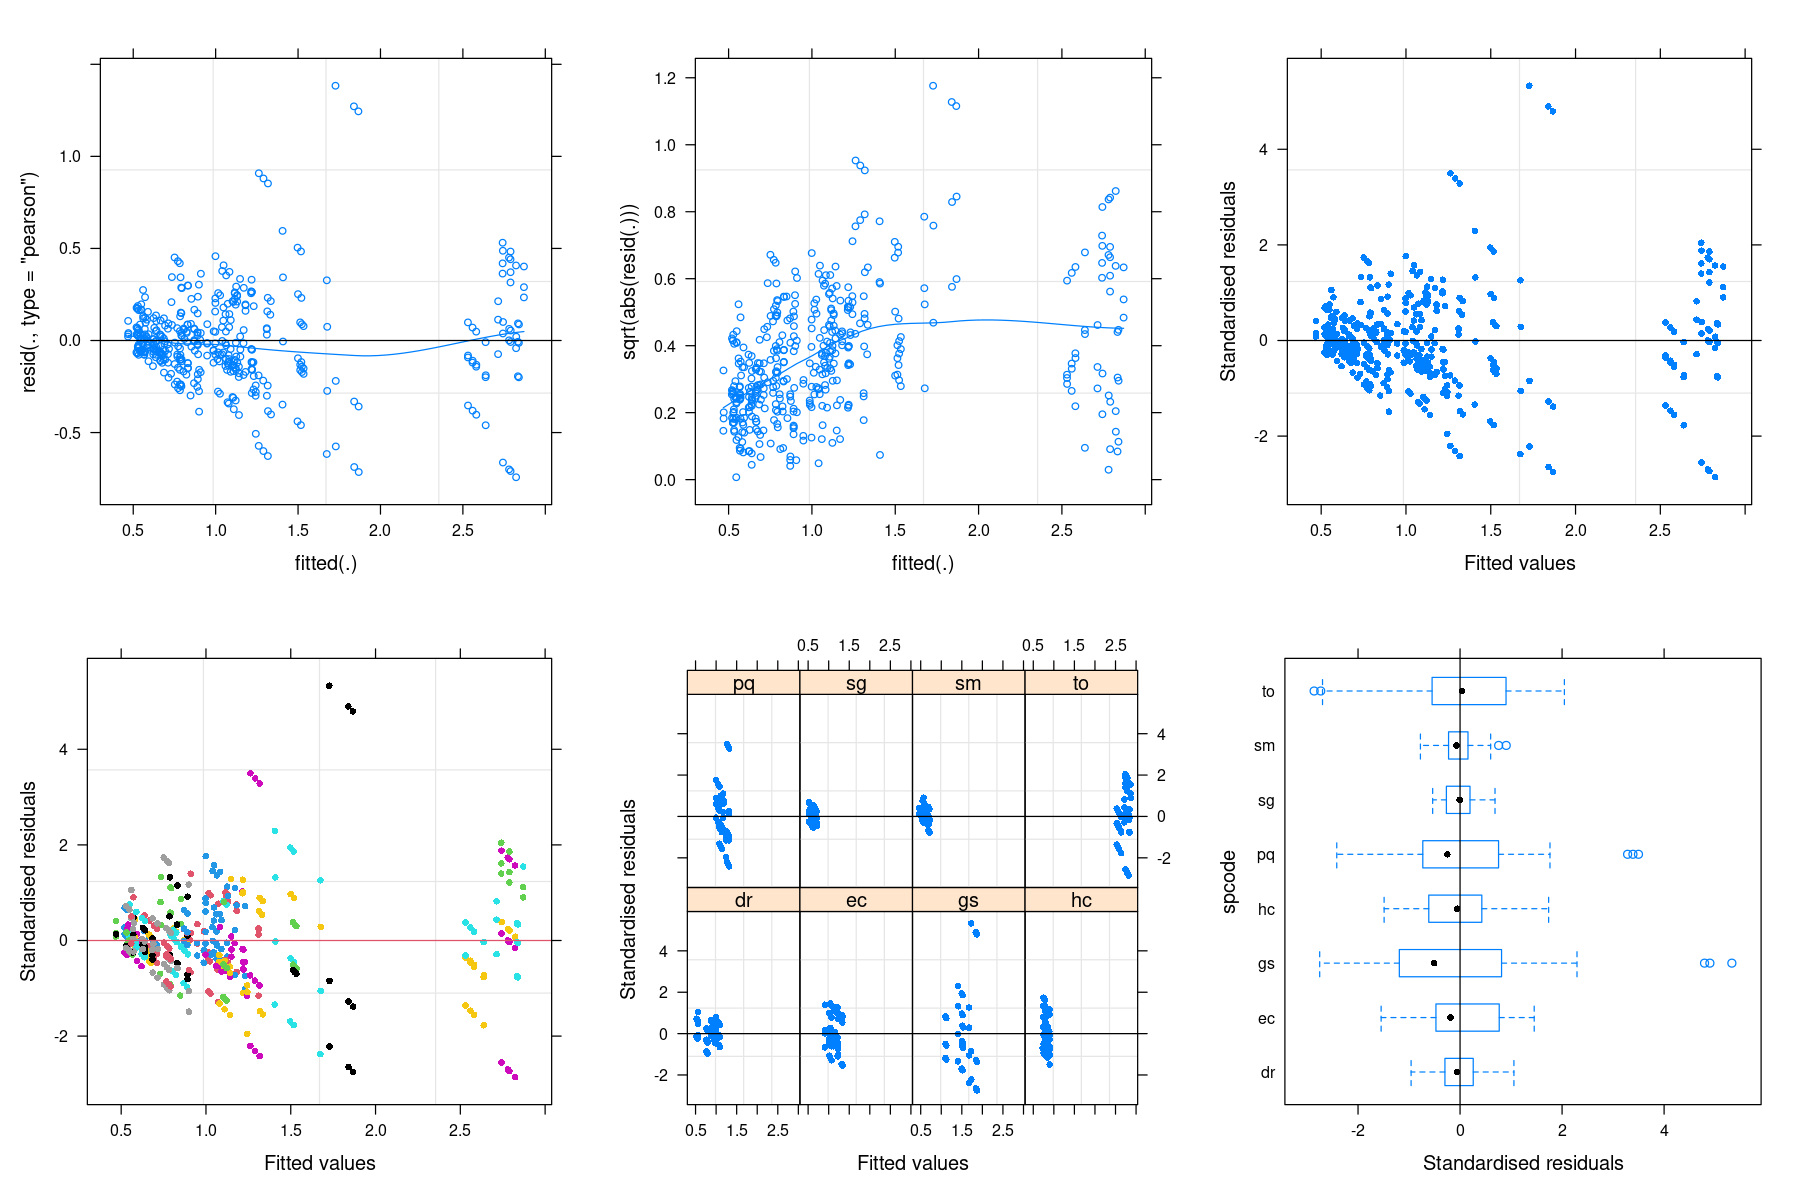

In [742]:
par(mfrow = c(3,3))
validation_plots(model_pc_root_shoot, data = data_for_models,group = "spcode")

## Model inference

In [743]:
## r2 models

r2(model_pc_total_biomass) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8279352|   0.4914417|FALSE    |

In [744]:
r2(model_pc_rgr) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.9214465|   0.4752463|FALSE    |

In [745]:
r2(model_pc_root_shoot) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.9071669|   0.0276726|FALSE    |

## Anova tables

### Total Biomass

In [746]:
Anova(model_pc_total_biomass, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.51584021,1,8.870715,2.498926e-01
treatment,54.34329636,3,405.460678,1.522184e-29
amax,2.78368589,1,408.727182,9.599460e-02
gs,8.15188924,1,404.936410,4.522878e-03
d13c,0.14145985,1,407.067213,7.070300e-01
sla,0.03288872,1,408.967562,8.561808e-01
nfixer,4.90761788,1,6.883821,6.294507e-02
init_height,25.91304199,1,348.023931,5.859213e-07
treatment:amax,4.79186864,3,406.096054,2.715126e-03


#### Amax

In [747]:
emtrends(model_pc_total_biomass,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()




|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -1.2531512| 0.5487113| 407.7889| -2.6686372|  0.1623348| -2.2838079| 0.1034851|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             |  0.2826640| 0.3715063| 403.9777| -0.6757317|  1.2410597|  0.7608592| 0.8719645|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.6378314| 0.3119561| 407.7607| -1.4425708|  0.1669080| -2.0446192| 0.1734753|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  1.5358152| 0.5464044| 407.2

#### gs

In [748]:
emtrends(model_pc_total_biomass,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|  lower.CL|   upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|---------:|----------:|----------:|---------:|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_nutrients)         | -0.4358863| 0.7215416| 403.8001| -2.297291|  1.4255184| -0.6041042| 0.9307404|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water)             | -1.9803992| 0.5914162| 405.3836| -3.506087| -0.4547117| -3.3485710| 0.0049051|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water_nutrients)   | -1.3370062| 0.3817157| 405.9909| -2.321719| -0.3522931| -3.5026226| 0.0028689|
|(gs-0.00451570905042949 plus_nutrients) - (gs-0.00451570905042949 plus_water)           | -1.5445129| 0.7368375| 404.9556| -3.445355|  0.3563290| -

#### d13c

In [749]:
emtrends(model_pc_total_biomass,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         |  0.3906110| 0.3177000| 406.3148| -0.4289577| 1.2101797|  1.2294965| 0.6084390|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             | -0.0143177| 0.2996551| 404.6155| -0.7873496| 0.7587142| -0.0477806| 0.9999608|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   | -0.0031622| 0.2716329| 404.4515| -0.7039054| 0.6975809| -0.0116415| 0.9999994|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.4049287| 0.3309292| 403.9210| -1.2586459| 

#### SLA

In [750]:
emtrends(model_pc_total_biomass,
        pairwise ~ sla*treatment,
        var = "sla")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_nutrients)         |  0.3768168| 0.3039462| 405.3242| -0.4072794|  1.1609130|  1.2397482| 0.6019066|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_water)             |  1.0930451| 0.3786568| 404.5713|  0.1162090|  2.0698811|  2.8866382| 0.0212853|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_water_nutrients)   |  0.1414139| 0.2506841| 405.1358| -0.5052822|  0.7881099|  0.5641119| 0.9426298|
|(sla-0.0163806167946636 plus_nutrients) - (sla-0.0163806167946636 plus_water)           |  0.7162283| 0.3879563| 403.6649| -0.2846074|  1.7170

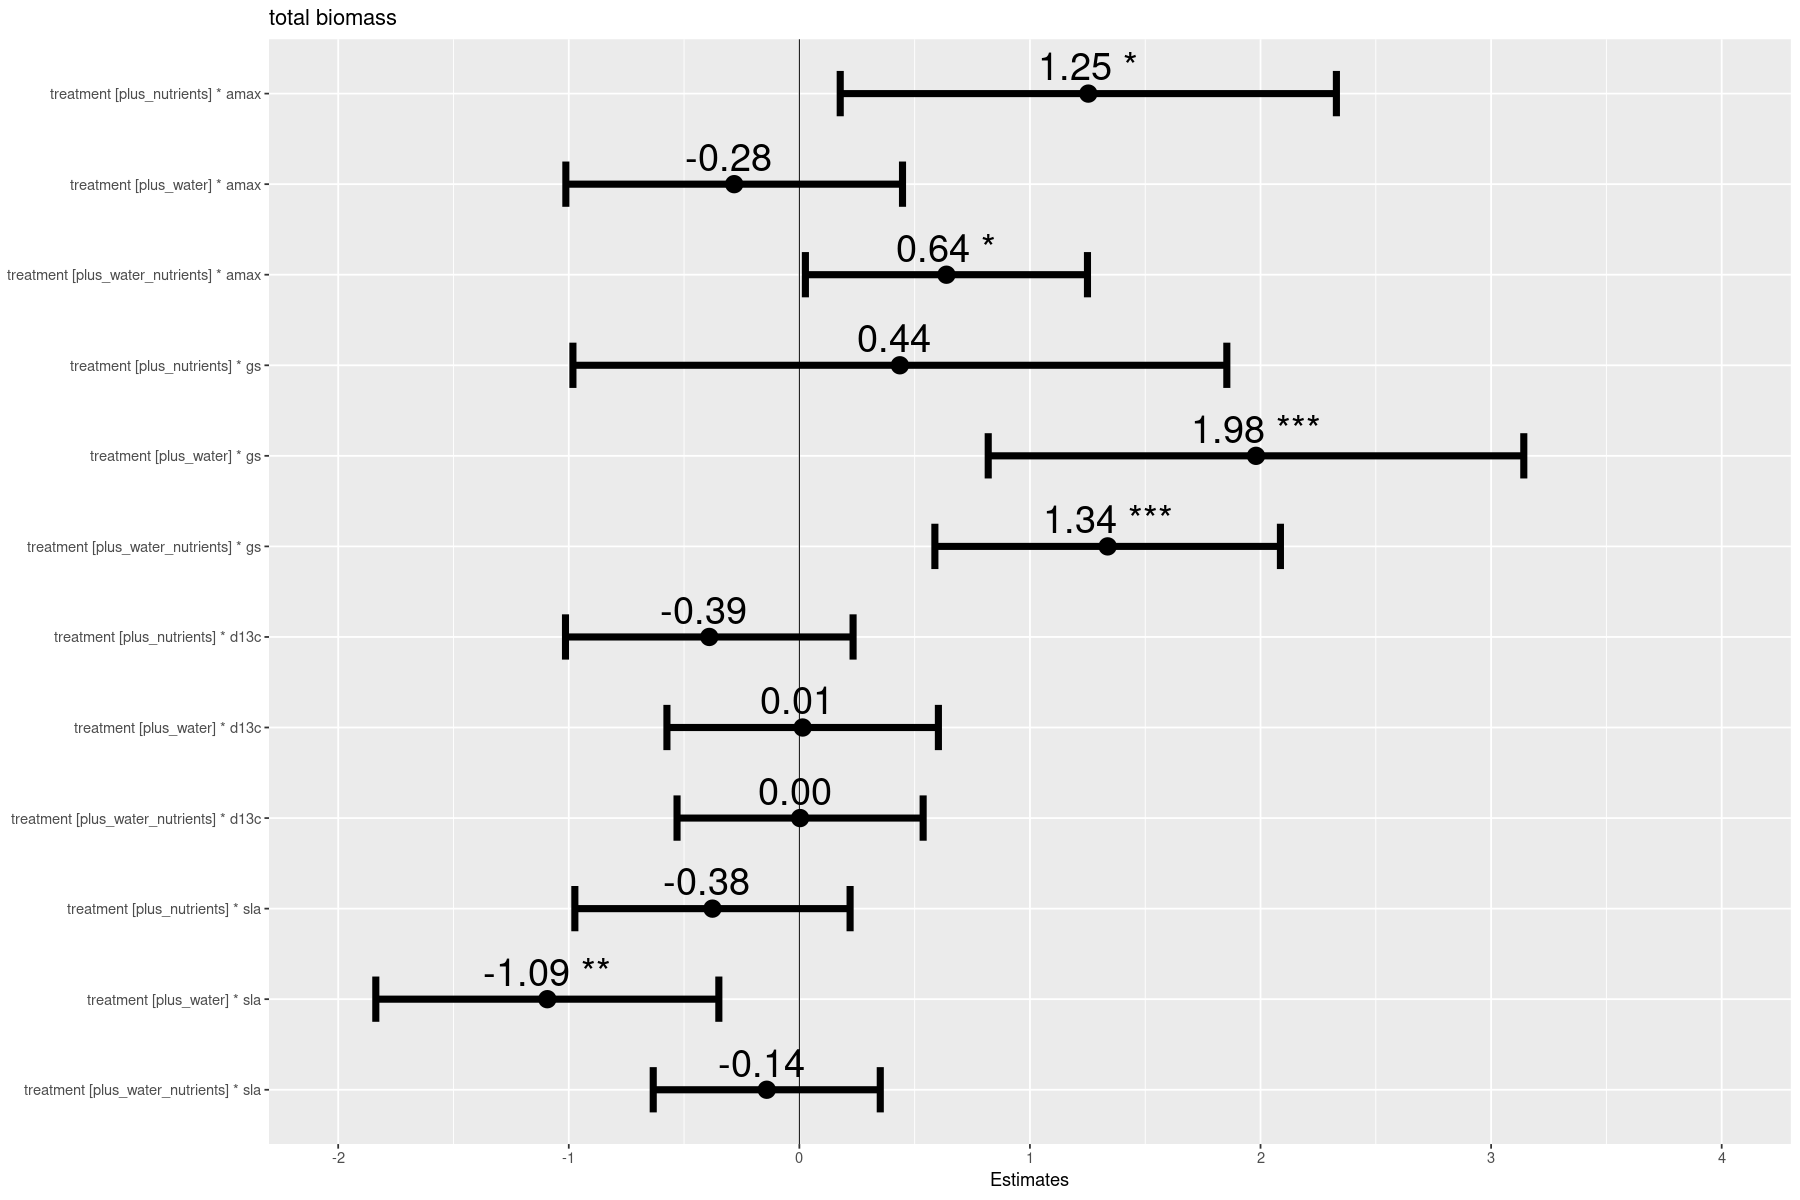

In [751]:
plot_model(model_pc_total_biomass, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "sla", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "sla:nfixerfixer"
                                    ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = TRUE,
                        )

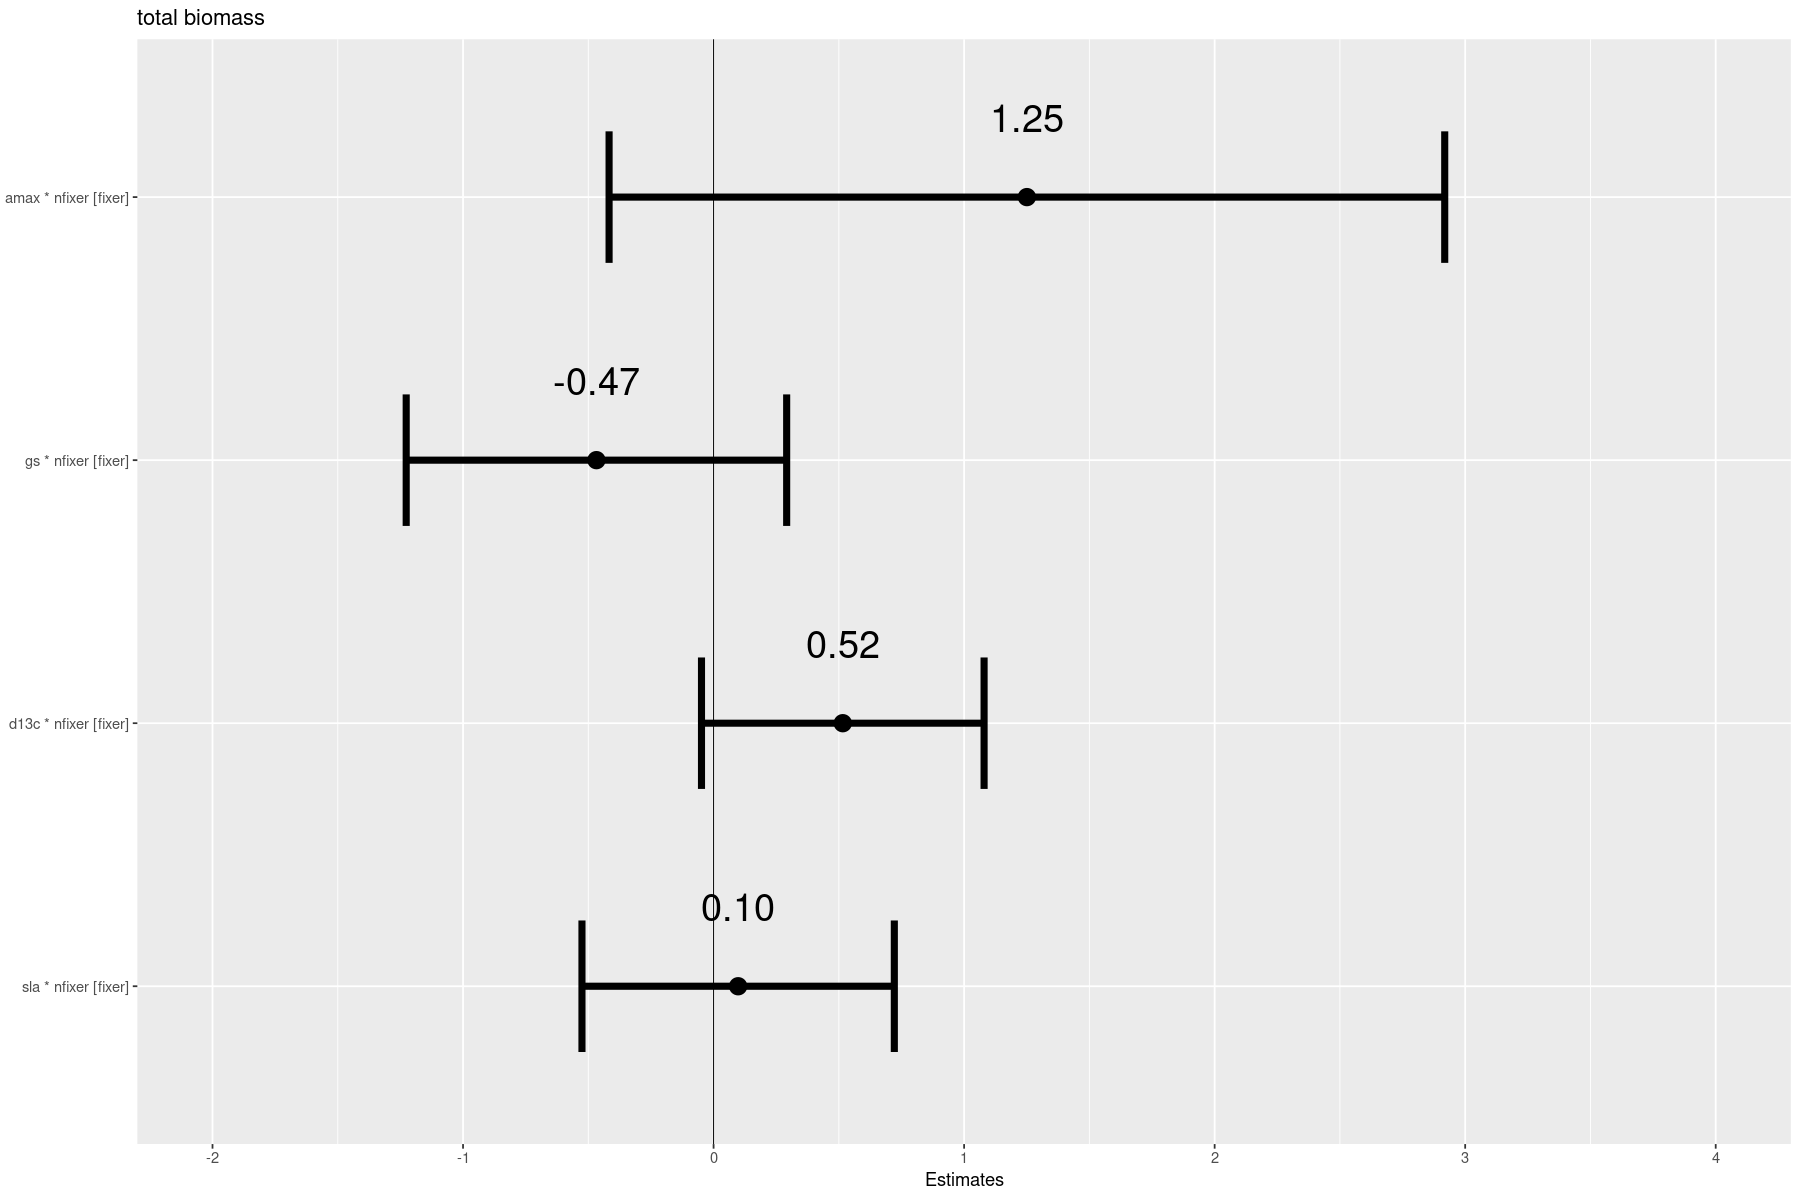

In [752]:
plot_model(model_pc_total_biomass, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "sla", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",

                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:sla",
                                     "treatmentplus_water:sla",
                                     "treatmentplus_water_nutrients:sla"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        )

### RGR 

In [753]:
Anova(model_pc_rgr, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),18.8237789,1,6.997001,3.405162e-03
treatment,40.5691257,3,404.062625,6.166501e-23
amax,1.6792077,1,405.830676,1.957663e-01
gs,5.4315476,1,403.739544,2.026796e-02
d13c,0.8731188,1,404.723057,3.506505e-01
sla,0.1656897,1,406.718461,6.841854e-01
nfixer,5.9197141,1,6.341403,4.877605e-02
init_height,115.9193358,1,406.616005,5.940518e-24
treatment:amax,5.4044392,3,404.413157,1.179672e-03


#### Amax

In [754]:
emtrends(model_pc_rgr,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.0005877| 0.0003884| 405.2566| -0.0015897|  0.0004143| -1.5131670| 0.4305058|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             |  0.0004783| 0.0002627| 403.3575| -0.0001994|  0.0011560|  1.8208305| 0.2649868|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.0003339| 0.0002208| 405.1721| -0.0009035|  0.0002357| -1.5124120| 0.4309585|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.0010661| 0.0003867| 404.9

#### gs

In [755]:
emtrends(model_pc_rgr,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_nutrients)         | -0.0005151| 0.0005102| 403.2990| -0.0018313| 0.0008011| -1.0095895| 0.7439103|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water)             | -0.0006898| 0.0004183| 403.9297| -0.0017689| 0.0003893| -1.6489894| 0.3523912|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water_nutrients)   | -0.0004483| 0.0002700| 404.1785| -0.0011448| 0.0002483| -1.6603069| 0.3462120|
|(gs-0.00451570905042949 plus_nutrients) - (gs-0.00451570905042949 plus_water)           | -0.0001747| 0.0005212| 403.7827| -0.0015191| 0.0011698| -

#### d13c

In [756]:
emtrends(model_pc_rgr,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         | -0.0002964| 0.0002248| 404.4230| -0.0008763| 0.0002835| -1.3184837| 0.5516573|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             | -0.0003011| 0.0002119| 403.6535| -0.0008478| 0.0002456| -1.4207936| 0.4870527|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   | -0.0001156| 0.0001921| 403.5657| -0.0006112| 0.0003799| -0.6020177| 0.9313923|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.0000047| 0.0002340| 403.3477| -0.0006084| 

#### SLA

In [757]:
emtrends(model_pc_rgr,
        pairwise ~ sla*treatment,
        var = "sla")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_nutrients)         | -0.0000931| 0.0002150| 403.8730| -0.0006477|  0.0004614| -0.4332727| 0.9727206|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_water)             |  0.0013602| 0.0002678| 403.5710|  0.0006694|  0.0020510|  5.0798350| 0.0000034|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_water_nutrients)   |  0.0000280| 0.0001773| 403.8055| -0.0004294|  0.0004854|  0.1578261| 0.9985986|
|(sla-0.0163806167946636 plus_nutrients) - (sla-0.0163806167946636 plus_water)           |  0.0014534| 0.0002743| 403.2377|  0.0007457|  0.0021

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


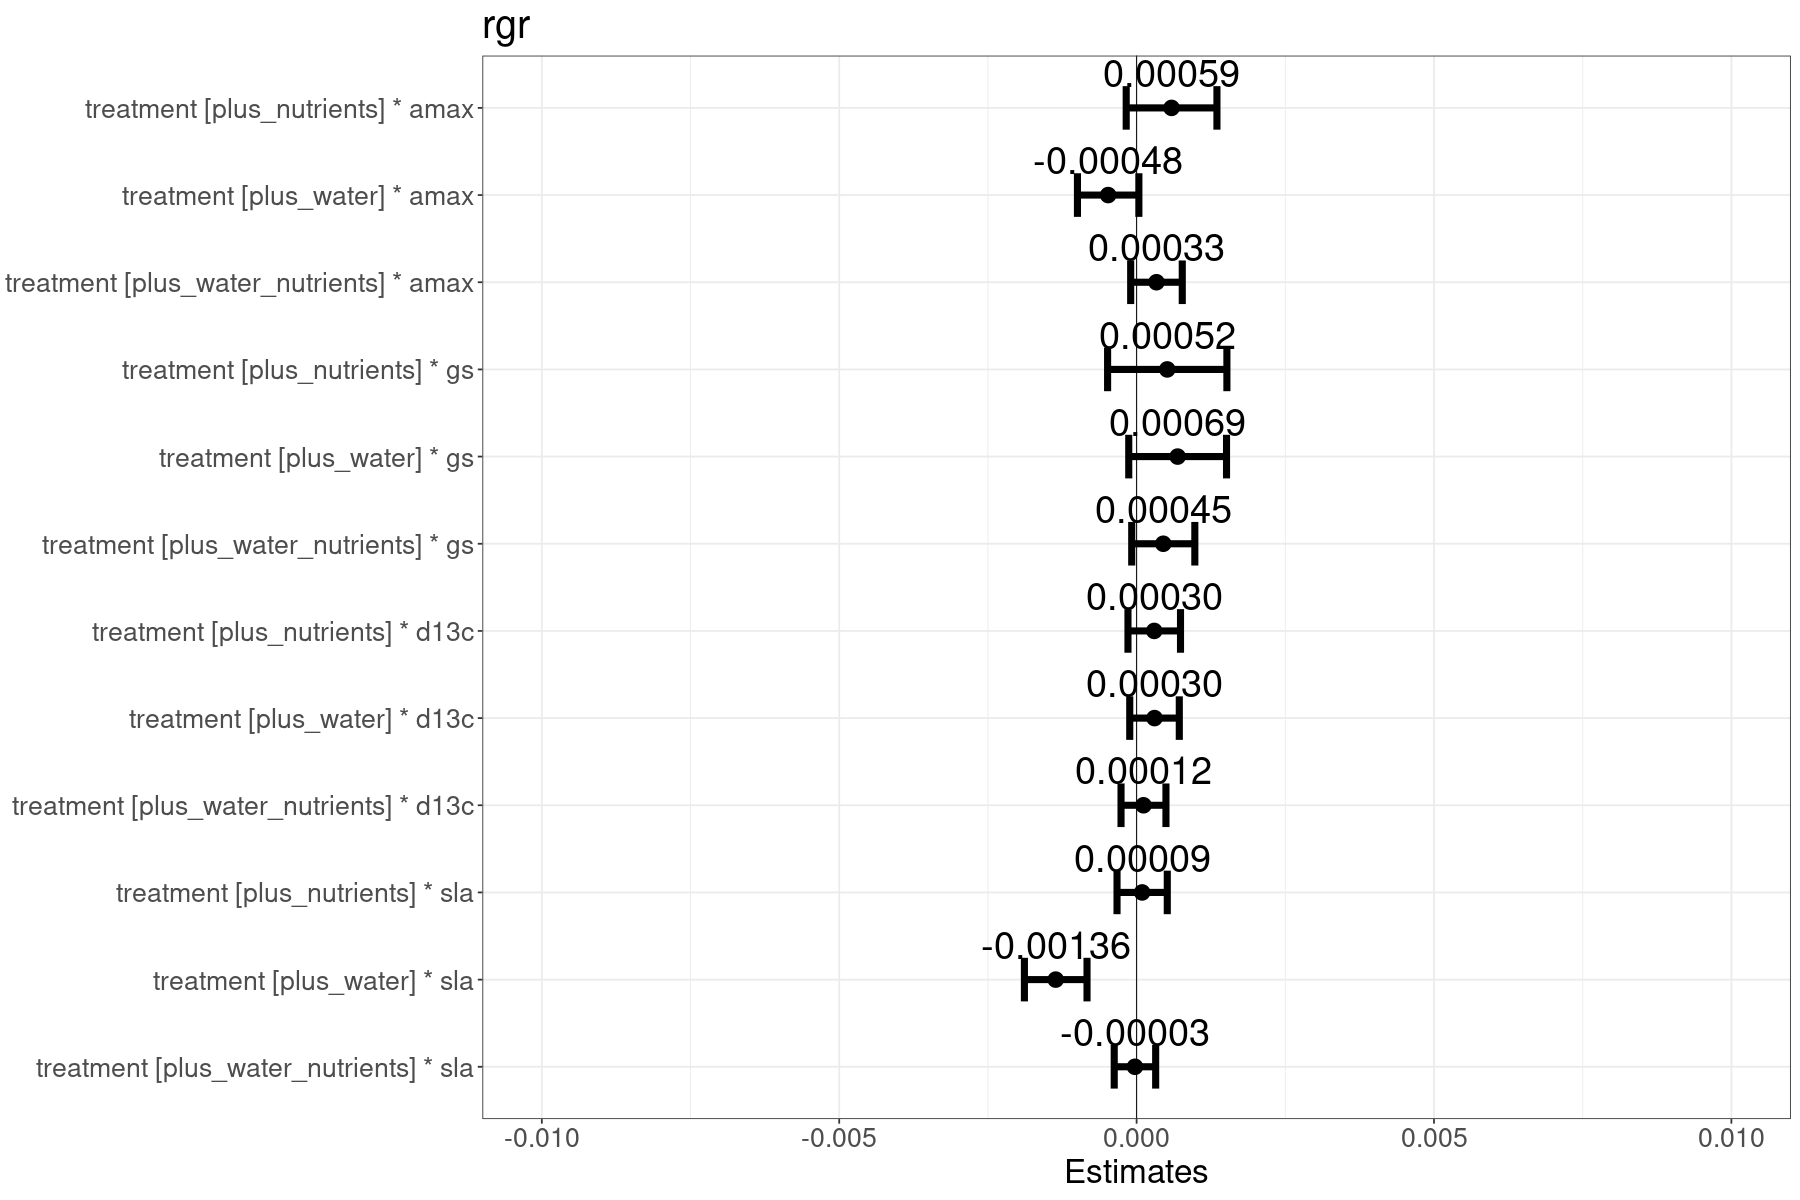

In [758]:
plot_model(model_pc_rgr, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "sla", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "sla:nfixerfixer"),
                        colors = "black",
                        value.offset = .4,
                        value.size = 8,
                        dot.size = 4,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,
                        digits = 5

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20)) +
                        ylim(-0.01,0.01)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


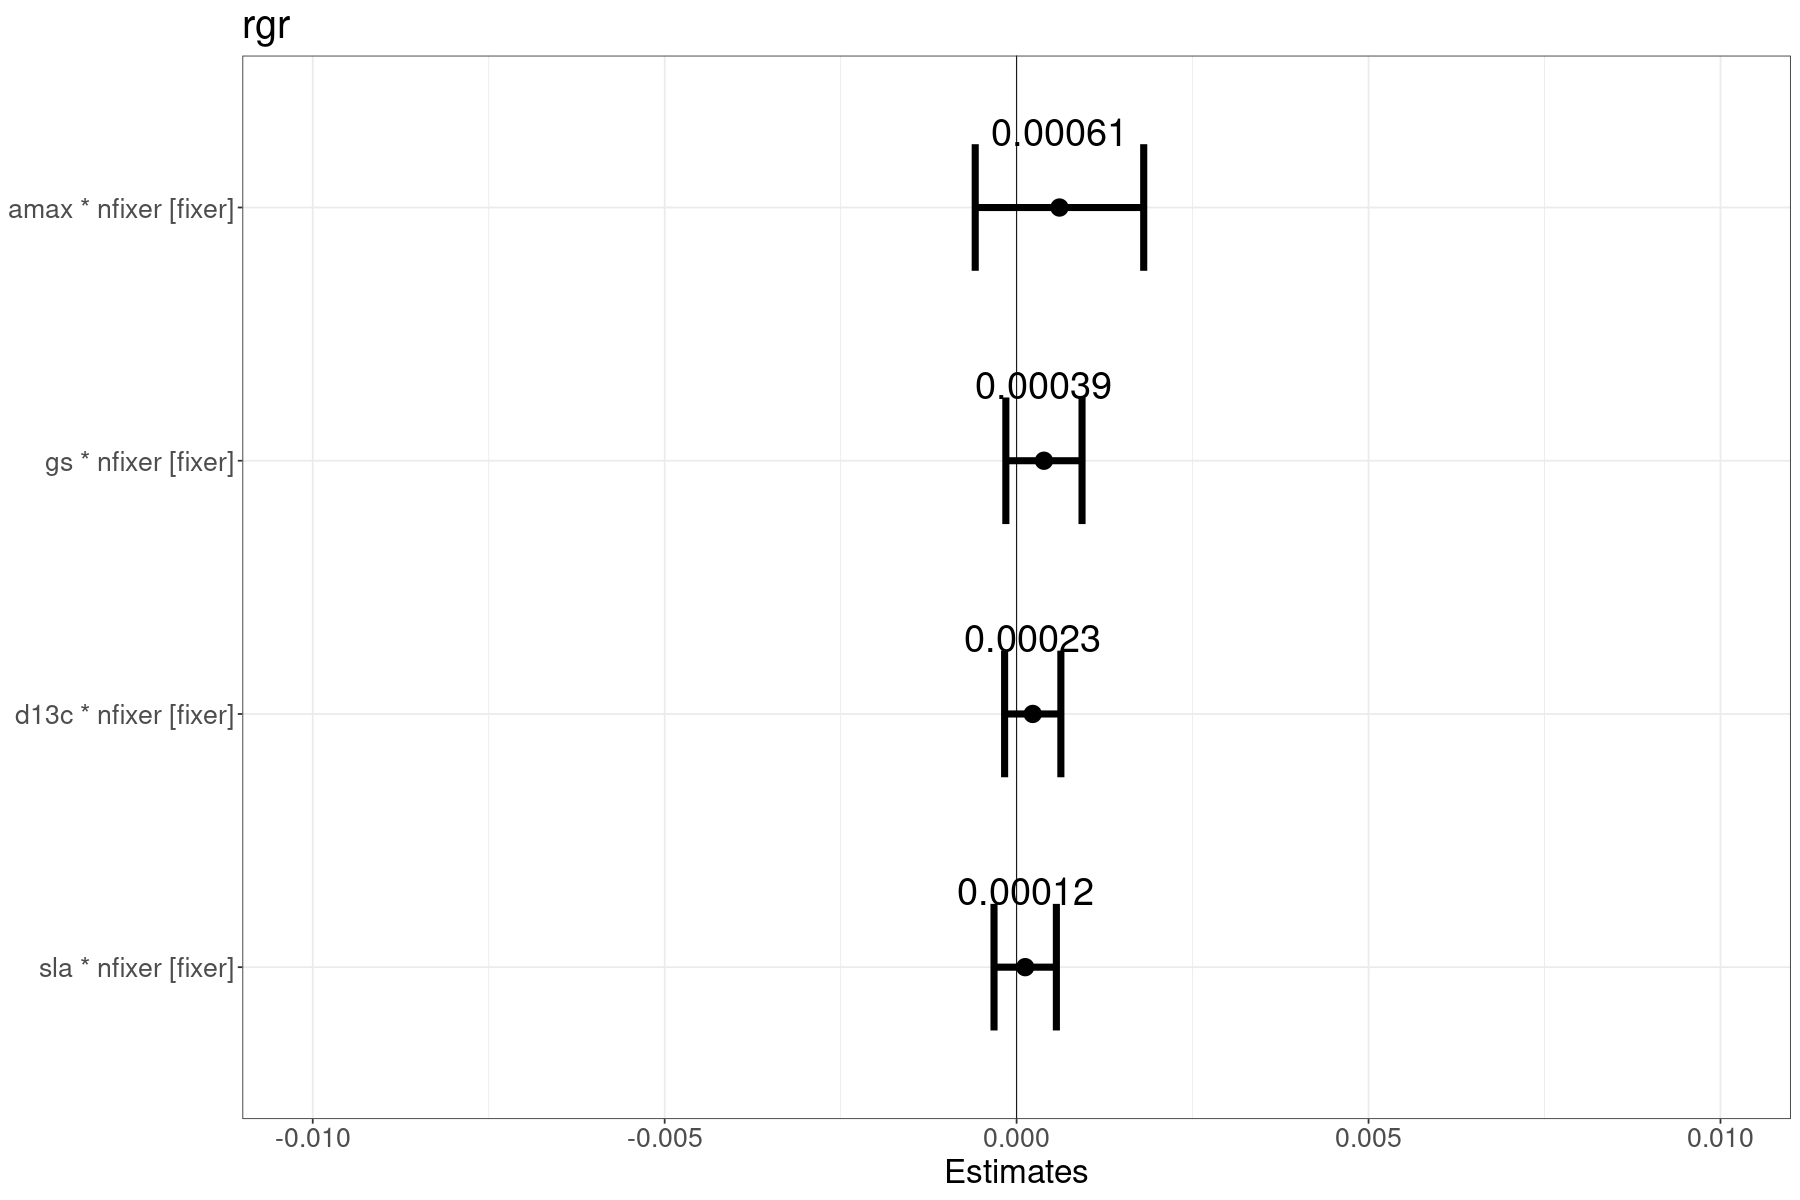

In [759]:
plot_model(model_pc_rgr, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "sla", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",



                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:sla",
                                     "treatmentplus_water:sla",
                                     "treatmentplus_water_nutrients:sla"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,
                        digits = 5

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20)) +
                        ylim(-0.01,0.01)

### Root to shoot ratio 

In [760]:
Anova(model_pc_root_shoot, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),9.539986081,1,6.597997,1.896574e-02
treatment,3.307797251,3,403.670063,2.020147e-02
amax,5.938640704,1,404.806518,1.524239e-02
gs,1.167303165,1,403.453330,2.806015e-01
d13c,0.548332235,1,404.078439,4.594300e-01
sla,0.427318306,1,405.456038,5.136783e-01
nfixer,0.042516274,1,6.209787,8.432337e-01
init_height,0.006249568,1,408.999369,9.370282e-01
treatment:amax,9.467289508,3,403.899660,4.666032e-06


#### Amax

In [761]:
emtrends(model_pc_root_shoot,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.3015741| 0.0773724| 404.4465| -0.5011751| -0.1019731| -3.8976957| 0.0006549|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             | -0.2433518| 0.0523196| 403.2171| -0.3783247| -0.1083790| -4.6512562| 0.0000265|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.1739048| 0.0439806| 404.3797| -0.2873637| -0.0604460| -3.9541220| 0.0005241|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.0582223| 0.0770324| 404.2

#### gs

In [762]:
emtrends(model_pc_root_shoot,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_nutrients)         |  0.1300048| 0.1016139| 403.1826| -0.1321364| 0.3921460|  1.2794003| 0.5765986|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water)             | -0.0250090| 0.0833144| 403.5728| -0.2399408| 0.1899229| -0.3001755| 0.9905918|
|(gs-0.00451570905042949 no_additions) - (gs-0.00451570905042949 plus_water_nutrients)   |  0.0004312| 0.0537789| 403.7265| -0.1383055| 0.1391680|  0.0080188| 0.9999998|
|(gs-0.00451570905042949 plus_nutrients) - (gs-0.00451570905042949 plus_water)           | -0.1550138| 0.1037977| 403.4855| -0.4227879| 0.1127604| -

#### d13c

In [763]:
emtrends(model_pc_root_shoot,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         |  0.1210968| 0.0447728| 403.8960|  0.0055938|  0.2365997|  2.7046964| 0.0357432|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             |  0.0683408| 0.0422100| 403.4063| -0.0405513|  0.1772328|  1.6190668| 0.3689902|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   |  0.0018640| 0.0382597| 403.3487| -0.0968373|  0.1005652|  0.0487194| 0.9999584|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.0527560| 0.0466057| 403.2128| -0.1729

#### SLA

In [764]:
emtrends(model_pc_root_shoot,
        pairwise ~ sla*treatment,
        var = "sla")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_nutrients)         |  0.0140852| 0.0428144| 403.5327| -0.0963660| 0.1245363|  0.3289822| 0.9876987|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_water)             | -0.0579580| 0.0533307| 403.3460| -0.1955391| 0.0796231| -1.0867661| 0.6978394|
|(sla-0.0163806167946636 no_additions) - (sla-0.0163806167946636 plus_water_nutrients)   |  0.0511345| 0.0353112| 403.4921| -0.0399603| 0.1422293|  1.4481081| 0.4701086|
|(sla-0.0163806167946636 plus_nutrients) - (sla-0.0163806167946636 plus_water)           | -0.0720432| 0.0546329| 403.1437| -0.2129840| 0.0688977| -

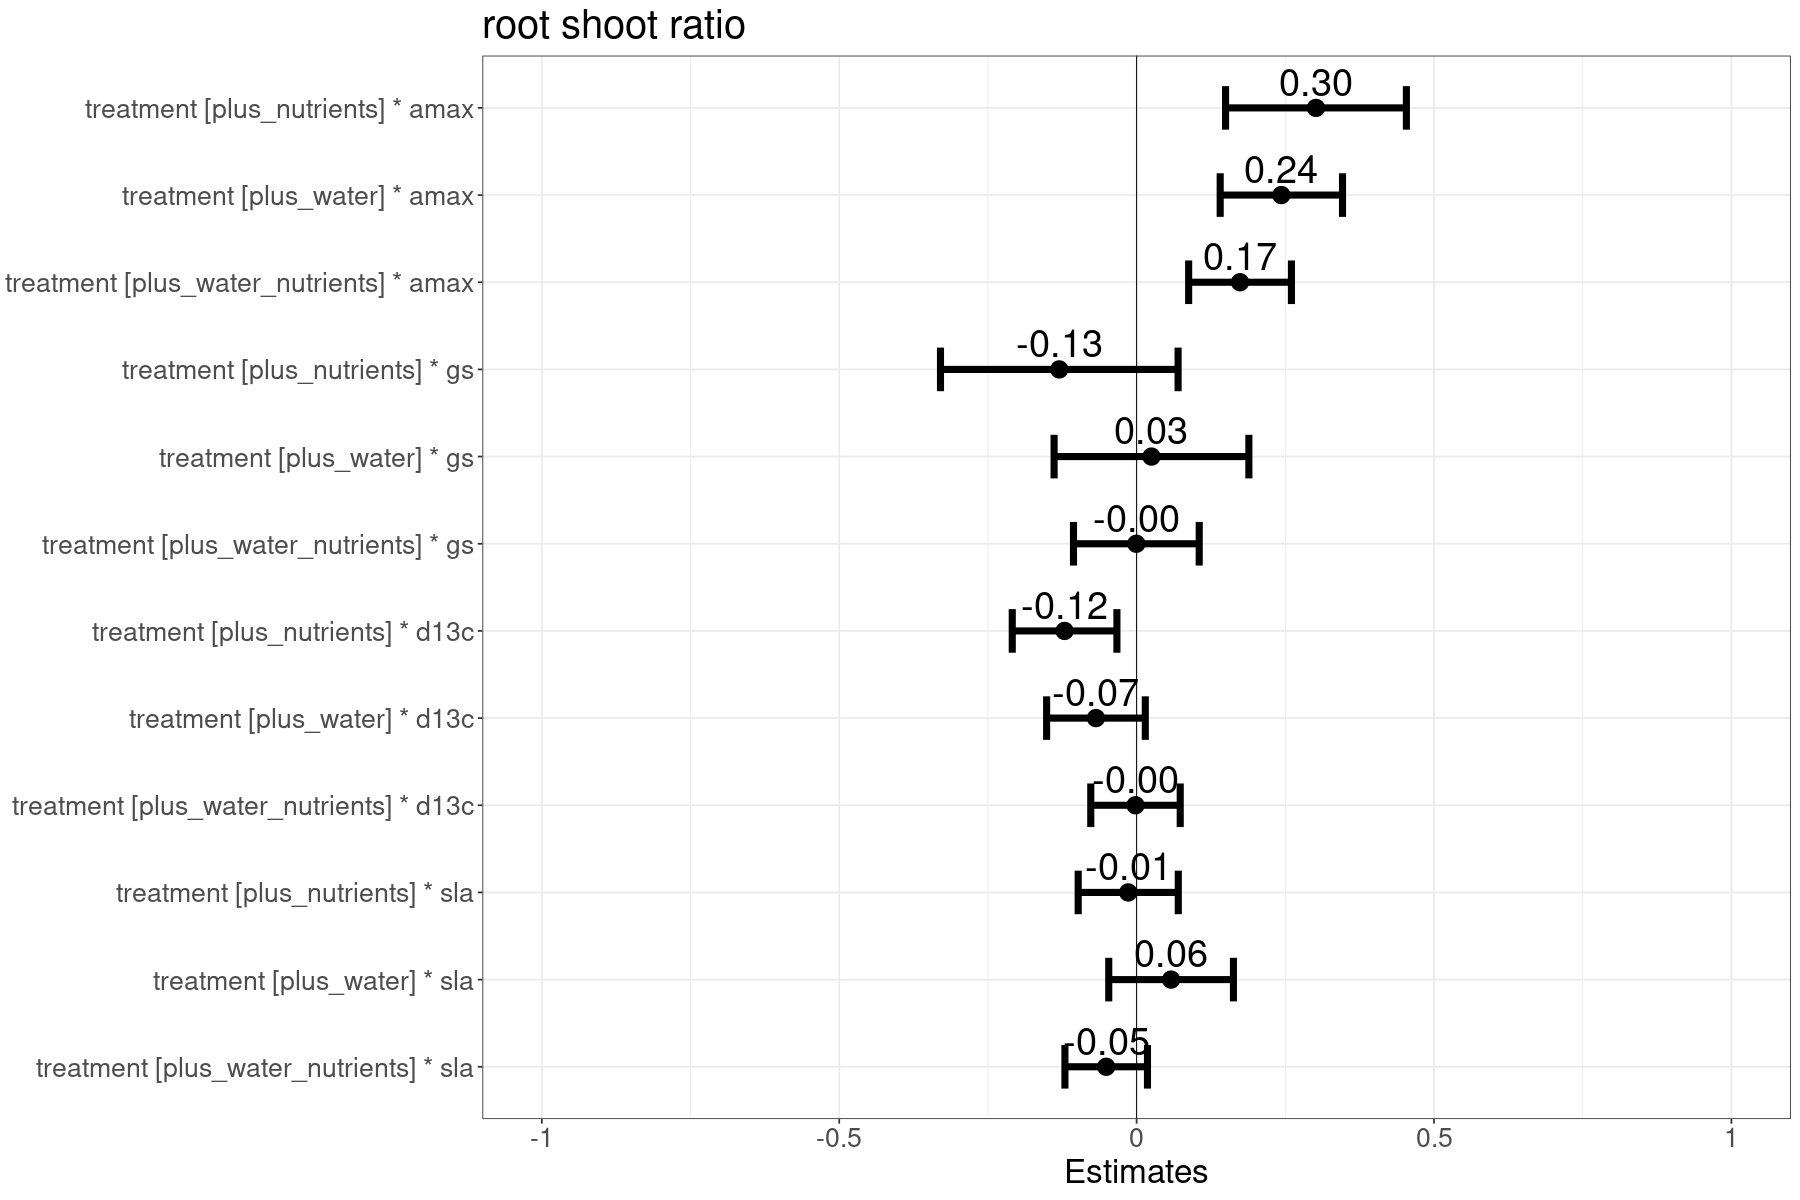

In [765]:
plot_model(model_pc_root_shoot, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "sla", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "sla:nfixerfixer"
                                    ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20))

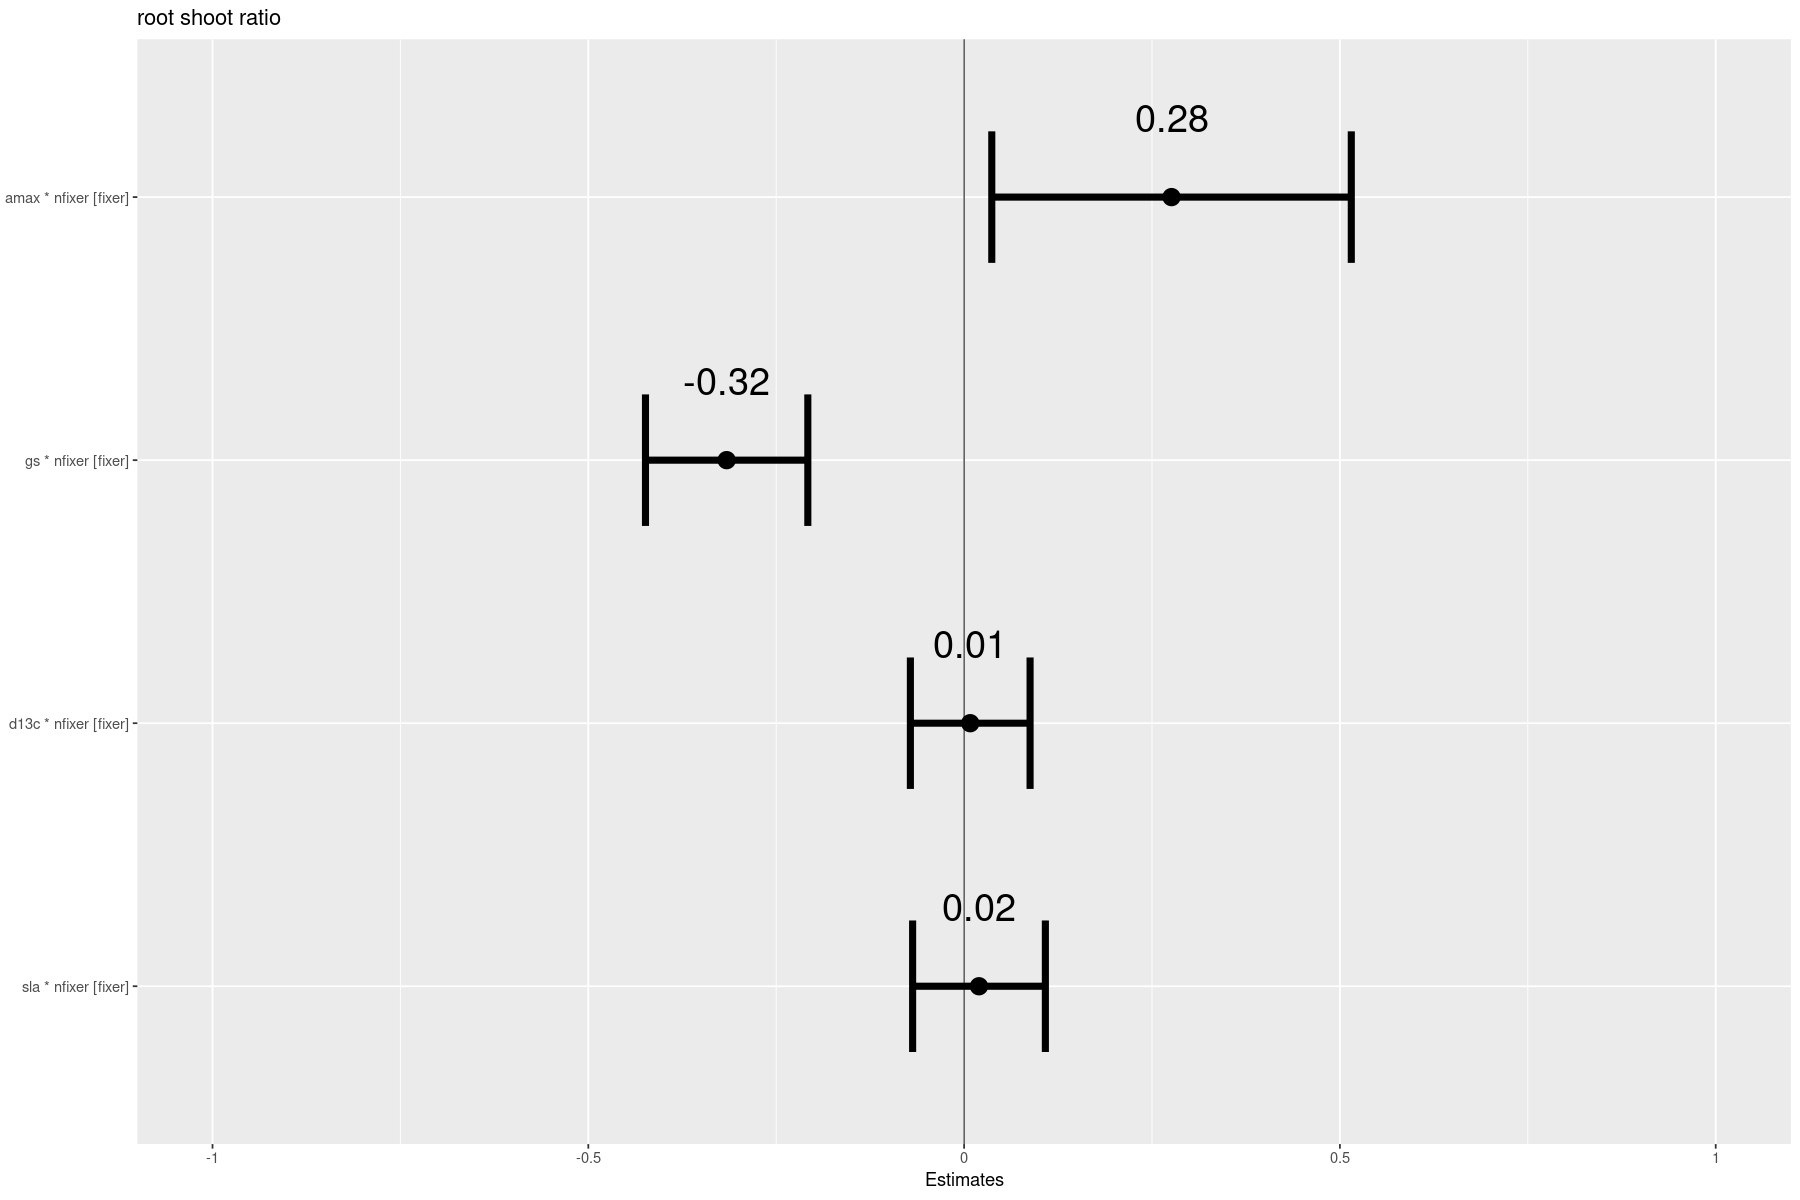

In [766]:
plot_model(model_pc_root_shoot, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "sla", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",

                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:sla",
                                     "treatmentplus_water:sla",
                                     "treatmentplus_water_nutrients:sla"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        )